https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [1]:
!wget https://raw.githubusercontent.com/juntaoduan/NLP_pretrained/main/data/news.csv

--2021-06-13 17:48:21--  https://raw.githubusercontent.com/juntaoduan/NLP_pretrained/main/data/news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/plain]
Saving to: ‘news.csv.2’

news.csv.2          100%[===================>]  29.27M  52.4MB/s    in 0.6s    

2021-06-13 17:48:22 (52.4 MB/s) - ‘news.csv.2’ saved [30696129/30696129]



#Preprocessing data

In [2]:
raw_data_path = '/content/news.csv'
destination_folder = '/content/'

train_test_ratio = 0.7
train_valid_ratio = 0.80


import pandas as pd
from sklearn.model_selection import train_test_split


# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)
df_raw

,label,title,text,titletext
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...
...,...,...,...,...
6330,0,State Department says it can't find emails fro...,The State Department told the Republican Natio...,State Department says it can't find emails fro...
6331,1,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,1,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,Anti-Trump Protesters Are Tools of the Oligarc...
6333,0,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...","In Ethiopia, Obama seeks progress on peace, se..."


In [3]:

# vary the number of words to use
i = 1
first_n_words = i*50

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 





# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

print(df_real.shape, df_fake.shape)

(3171, 4) (3128, 4)


In [4]:

"""
df_train['text'] = df_train['text'].apply(trim_string)
df_train['titletext'] = df_train['titletext'].apply(trim_string) 
df_valid['text'] = df_valid['text'].apply(trim_string)
df_valid['titletext'] = df_valid['titletext'].apply(trim_string) 
df_test['text'] = df_test['text'].apply(trim_string)
df_test['titletext'] = df_test['titletext'].apply(trim_string) 
"""


"\ndf_train['text'] = df_train['text'].apply(trim_string)\ndf_train['titletext'] = df_train['titletext'].apply(trim_string) \ndf_valid['text'] = df_valid['text'].apply(trim_string)\ndf_valid['titletext'] = df_valid['titletext'].apply(trim_string) \ndf_test['text'] = df_test['text'].apply(trim_string)\ndf_test['titletext'] = df_test['titletext'].apply(trim_string) \n"

# Parameters

In [5]:
destination_folder = '/content/'
source_folder = destination_folder

# Libraries

In [6]:
# method 1 (official pip)
!pip install transformers

# method 2
# download a local transformer and modify
#!git clone https://github.com/huggingface/transformers.git


#- modify code of BertForSequenceClassification in line 1462 of 
#'/content/transformers/src/transformers/models/bert/modeling_bert.py'

# install the modified transformer
#!pip install /content/transformers

In [7]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models
# source code BertForSequenceClassification
# https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

####choose pretrained checkpoint

In [9]:
# https://huggingface.co/transformers/pretrained_models.html
Largebert = False
if Largebert:
    pretrain_models = 'bert-large-uncased'
else:
    pretrain_models = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrain_models)


In [10]:
import nltk #Natural Language Toolkit
import re #regular expression
from nltk.corpus import stopwords
nltk.download('stopwords')
# stop_words=stopwords.words('english') 
# Bert model does like stop words, there is no need to remove

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Model parameter
MAX_SEQ_LEN = first_n_words
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields (data formating pipeline)
# pipeline for labels
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
# pipeline for text
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                    fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

trainset, validset, testset = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(trainset, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(validset, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(testset, batch_size=8, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors


In [12]:
MAX_SEQ_LEN

50

# Models

In [13]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        if Largebert:
            options_name = "bert-large-uncased"
        else:
            options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [15]:
if Largebert:
    version = 'Lv1'
else: 
    version = 'v'+str(i) # 'v1'

In [16]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(), # Binary cross entropy
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + version+'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


BertPooler: 
* input: last hidden states from decoder [8, 10, 768] = [N, L, E]
* take out first hidden states: [8, 1, 768] #first of L
* then use a dense layer with activation tanh()
```
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        #print('hidden ', hidden_states.shape)
        first_token_tensor = hidden_states[:, 0]
        #print('hidden first ', first_token_tensor.shape)
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
```



In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

load_checkpoint(destination_folder + '/v3model.pt', model)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v3model.pt
Epoch [1/10], Step [220/4410], Train Loss: 0.0266, Valid Loss: 0.0879
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v6model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/metrics.pt
Epoch [1/10], Step [440/4410], Train Loss: 0.0259, Valid Loss: 0.1058
Epoch [2/10], Step [660/4410], Train Loss: 0.0212, Valid Loss: 0.1819
Epoch [2/10], Step [880/4410], Train Loss: 0.0078, Valid Loss: 0.1306
Epoch [3/10], Step [1100/4410], Train Loss: 0.0107, Valid Loss: 0.1006
Epoch [3/10], Step [1320/4410], Train Loss: 0.0080, Valid Loss: 0.1068
Epoch [4/10], Step [1540/4410], Train Loss: 0.0236, Valid Loss: 0.0800
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v6model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/metrics.pt
Epoch [4/10], Step [1760/4410], Train Loss: 0.0133, Valid Loss: 0.1315
Epoch [5/10], Step

In [17]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#load_checkpoint(destination_folder + '/v2model.pt', model)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/10], Step [28/560], Train Loss: 0.6210, Valid Loss: 0.4820
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [1/10], Step [56/560], Train Loss: 0.3951, Valid Loss: 0.3002
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [2/10], Step [84/560], Train Loss: 0.3352, Valid Loss: 0.2587
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [2/10], Step [112/560], Train Loss: 0.2124, Valid Loss: 0.2155
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [3/10], Step [140/560], Train Loss: 0.2467, Valid Loss: 0.2069
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [3/10], Step [168/560], Train Loss: 0.1383, Valid Loss: 0.1962
Model saved to ==> /content//v1model.pt
Model saved to ==> /content//metrics.pt
Epoch [4/10], Step [196/560], Train Loss: 0.1725, Valid Loss: 0.1791
Model saved to ==> /content//v1model.pt


Model loaded from <== /content//metrics.pt


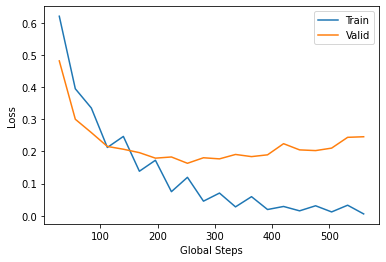

In [18]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [22]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content//v1model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9565    0.9127    0.9341       939
           0     0.9176    0.9590    0.9379       952

    accuracy                         0.9360      1891
   macro avg     0.9370    0.9359    0.9360      1891
weighted avg     0.9369    0.9360    0.9360      1891



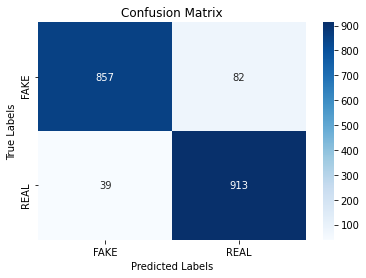

In [23]:
#model v1
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/v1model.pt', best_model)
evaluate(best_model, test_iter)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v2model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9751    0.9585    0.9667       939
           0     0.9597    0.9758    0.9677       952

    accuracy                         0.9672      1891
   macro avg     0.9674    0.9672    0.9672      1891
weighted avg     0.9673    0.9672    0.9672      1891



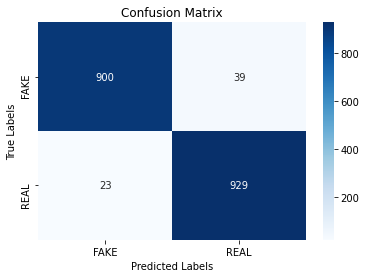

In [ ]:
#model v2
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/v2model.pt', best_model)
evaluate(best_model, test_iter)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v3model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9670    0.9681    0.9675       939
           0     0.9685    0.9674    0.9679       952

    accuracy                         0.9677      1891
   macro avg     0.9677    0.9677    0.9677      1891
weighted avg     0.9677    0.9677    0.9677      1891



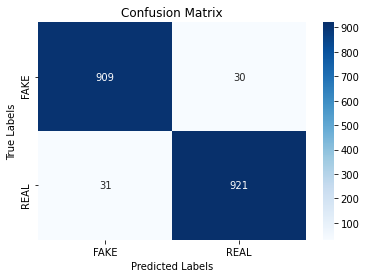

In [ ]:
#model v3
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/v3model.pt', best_model)
evaluate(best_model, test_iter)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/NLP/News_fake/v5model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9806    0.9681    0.9743       939
           0     0.9689    0.9811    0.9749       952

    accuracy                         0.9746      1891
   macro avg     0.9747    0.9746    0.9746      1891
weighted avg     0.9747    0.9746    0.9746      1891



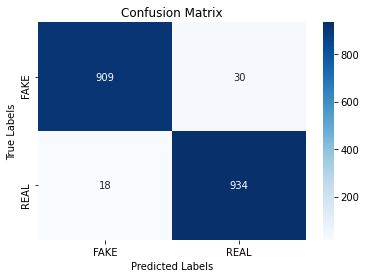

In [ ]:
#model v5
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/v5model.pt', best_model)
evaluate(best_model, test_iter)
